In [1]:
# Libraries
import pandas as pd
from pandas import DataFrame
from nltk import edit_distance
from fuzzywuzzy import fuzz
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import itertools
import numpy as np

In [2]:
from nltk.corpus import stopwords

In [3]:
# Get data
# df = pd.read_csv("cust10k.csv", delimiter="|")
file = "./affiliationstrings/affiliationstrings_ids.csv"
df = pd.read_csv(file, index_col=0)
df.columns=["entityname"]

In [4]:
df.head()

,entityname
id1,
7927,", IBM Almaden Research Center, 650 Harry Road,..."
7930,", IIT Bombay"
7987,", University of California, San Diego, USA"
5613,"28msec Inc., Zurich, Switzerland"
9530,"28msec, Inc."


In [5]:
df.loc[8544]

entityname    Department of Computer Engineering, Kyungpook ...
Name: 8544, dtype: object

In [6]:
df.shape

(2260, 1)

In [7]:
df.columns = ["entityname_original"]

In [8]:
df.head()

,entityname_original
id1,
7927,", IBM Almaden Research Center, 650 Harry Road,..."
7930,", IIT Bombay"
7987,", University of California, San Diego, USA"
5613,"28msec Inc., Zurich, Switzerland"
9530,"28msec, Inc."


In [9]:
# Stopword removal and lowercase conversion
# stop = stopwords.words("english")
# df["entityname"] = df["entityname_original"].apply(lambda x: " ".join(word for word in x.lower().split(" ") if word not in stop))
df["entityname"] = df["entityname_original"]

In [10]:
df.sample(5)

,entityname_original,entityname
id1,,
8004,"Columbia University, New York, New York","Columbia University, New York, New York"
8286,"University of Helsinki, Finland","University of Helsinki, Finland"
7867,Department of Computer Science and Engineering...,Department of Computer Science and Engineering...
170,"Kent State University, Kent, OH","Kent State University, Kent, OH"
8687,Department of Computer Science and Engineering...,Department of Computer Science and Engineering...


In [11]:
def setup():
    # Add a column to store grouping
    df["GroupA"] = None
    df["GroupB"] = None
    df["GroupC"] = None
    df["GroupD"] = None
    df["GroupE"] = None
    df["GroupF"] = None
    df["GroupG"] = None
    df["GroupH"] = None
    df["GroupI"] = None
    df["GroupJ"] = None
    df["GroupA_id1"] = None
    df["GroupB_id1"] = None
    df["GroupC_id1"] = None
    df["GroupD_id1"] = None
    df["GroupE_id1"] = None
    df["GroupF_id1"] = None
    df["GroupG_id1"] = None
    df["GroupH_id1"] = None
    df["GroupI_id1"] = None
    df["GroupJ_id1"] = None
    df["GroupA_score"] = None
    df["GroupB_score"] = None
    df["GroupC_score"] = None
    df["GroupD_score"] = None
    df["GroupE_score"] = None
    df["GroupF_score"] = None
    df["GroupG_score"] = None
    df["GroupH_score"] = None
    df["GroupI_score"] = None
    df["GroupJ_score"] = None

In [12]:
# Test average score method
testname1 = "A Fast food Chain #3456"
testname2 = "Chain Fastfood #3456"
fuzz_ratio = fuzz.ratio(testname1, testname2)
fuzz_partial = fuzz.partial_ratio(testname1, testname2)
fuzz_tokensort = fuzz.token_sort_ratio(testname1, testname2)
similarity_score = (fuzz_ratio+fuzz_partial+fuzz_tokensort)/3

print(f"fuzz: {fuzz_ratio}, partial: {fuzz_partial}, tokensort: {fuzz_tokensort}, similarity_score: {similarity_score}")

fuzz: 70, partial: 65, tokensort: 93, similarity_score: 76.0


In [13]:
setup() # RUN THIS FIRST!!!

In [14]:
groups = ["GroupA", "GroupB", "GroupC", "GroupD", "GroupE", "GroupF", "GroupG", "GroupH", "GroupI", "GroupJ"]

for g in groups:
    print(f"Starting: {g}")
    print("=" * 72)
    initial = datetime.now()
    df = df.sample(frac=1)
    # indices of names for looping
    list_idx = [idx for idx in df.index]
    
    # Loop through names
#     num_records = 100 # restrict for debug
#     for idx in list_idx[:num_records]: # restrict for debug
    
    for idx in list_idx:
#         print("-" * 72)
        current_name = df.loc[idx]['entityname']
#         print(f"idx:{idx} name to compare: {current_name}")
        
    
        if df.loc[idx][g] is None:
            idx_to_compare = list_idx[list_idx.index(idx)+1:]
            for i in idx_to_compare:
                if df.loc[i][g] is None:
                    compare_name = df.loc[i]["entityname"]
                    fuzz_ratio = fuzz.ratio(current_name, compare_name)
                    fuzz_partial = fuzz.partial_ratio(current_name, compare_name)
                    fuzz_tokensort = fuzz.token_sort_ratio(current_name, compare_name)
                    similarity_score = (fuzz_ratio+fuzz_partial+fuzz_tokensort)/3 # Average of 3 different ratios
                    if similarity_score > 75:
    #                     print(f"Similarity score:{similarity_score}")
                        df.loc[df.index == i, g] = current_name
                        df.loc[df.index == i, g+"_score"] = similarity_score
                        df.loc[df.index == i, g+"_id1"] = idx
#         else:
#             print(f"{current_name} already matched. Skipping.")
    
    
    
    final = datetime.now()
    total_time = final - initial
    print("=" * 72)
    print(f"Group {g} total time: {total_time}")

print("Saving groups...")
df.to_csv("edit_dist_dedup_groups.csv")
print("Save complete!")

Starting: GroupA
Group GroupA total time: 0:05:36.762364
Starting: GroupB
Group GroupB total time: 0:05:48.222565
Starting: GroupC
Group GroupC total time: 0:05:49.565604
Starting: GroupD
Group GroupD total time: 0:05:39.247284
Starting: GroupE
Group GroupE total time: 0:05:40.125143
Starting: GroupF
Group GroupF total time: 0:05:37.110977
Starting: GroupG
Group GroupG total time: 0:05:40.271472
Starting: GroupH
Group GroupH total time: 0:05:41.837566
Starting: GroupI
Group GroupI total time: 0:05:40.663504
Starting: GroupJ
Group GroupJ total time: 0:05:42.608019
Saving groups...
Save complete!


In [15]:
# group = "GroupA"
# print(f"Number of matches: {df[group].value_counts().sum()}")
# print(f"Number of groups: {len(df[group].unique())}")
# df[group].value_counts()[:10]

In [16]:
# df.loc[df["entityname"].str.contains("AT&T")].head()

Remove duplicate permutations of tuples:

https://stackoverflow.com/questions/15352995/removing-permutations-from-a-list-of-tuples

In [17]:
matches_temp = list(set(list(zip(df["GroupA_id1"].index, df["GroupA_id1"].values)) + \
        list(zip(df["GroupB_id1"].index, df["GroupB_id1"].values)) + \
        list(zip(df["GroupC_id1"].index, df["GroupC_id1"].values)) + \
        list(zip(df["GroupD_id1"].index, df["GroupD_id1"].values)) + \
        list(zip(df["GroupE_id1"].index, df["GroupE_id1"].values)) + \
        list(zip(df["GroupF_id1"].index, df["GroupF_id1"].values)) + \
        list(zip(df["GroupG_id1"].index, df["GroupG_id1"].values)) + \
        list(zip(df["GroupH_id1"].index, df["GroupH_id1"].values)) + \
        list(zip(df["GroupI_id1"].index, df["GroupI_id1"].values)) + \
        list(zip(df["GroupJ_id1"].index, df["GroupJ_id1"].values))))

matches = []
for m in matches_temp:
    if m[0] is not None and m[1] is not None:
        matches.append(m)

# Remove permutation duplicates
matches = list(set(tuple(sorted(t)) for t in matches))

In [18]:
len(matches)

5569

In [19]:
matches[:10]

[(6505, 6528),
 (1476, 8078),
 (6150, 6549),
 (9136, 9376),
 (3826, 5566),
 (5268, 9709),
 (1837, 2065),
 (5311, 5366),
 (679, 5136),
 (1837, 2038)]

In [20]:
df_matches = pd.DataFrame(matches)
df_matches.columns = ["entityid1", "entityid2"]
# df_matches.set_index("entityid1", inplace=True)
df_matches["match_string"] = df_matches.apply(lambda row: str(row["entityid1"])+"|"+str(row["entityid2"]), axis=1)
df_matches.head()

,entityid1,entityid2,match_string
0,6505,6528,6505|6528
1,1476,8078,1476|8078
2,6150,6549,6150|6549
3,9136,9376,9136|9376
4,3826,5566,3826|5566


In [21]:
# Get ground truth
file = "./affiliationstrings/affiliationstrings_mapping.csv"
df_truth = pd.read_csv(file, index_col=0, header=None, names=["entityid1", "entityid2"])

In [22]:
truth_tuples = list(df_truth.reset_index().to_records(index=False))
truth_unique = list(set(tuple(sorted(t)) for t in truth_tuples))
truth_unique[:10]

[(3460, 6963),
 (1808, 4095),
 (3265, 9562),
 (2551, 5771),
 (6605, 7876),
 (3842, 9044),
 (6150, 6549),
 (4208, 9532),
 (9136, 9376),
 (2927, 8872)]

In [23]:
len(truth_unique)

16408

In [24]:
df_truthunique = pd.DataFrame(truth_unique)
df_truthunique.columns = ["entityid1", "entityid2"]
# df_truthunique.set_index("entityid1", inplace=True)
df_truthunique["match_string"] = df_truthunique.apply(lambda row: str(row["entityid1"])+"|"+str(row["entityid2"]), axis=1)
df_truthunique.head()

,entityid1,entityid2,match_string
0,3460,6963,3460|6963
1,1808,4095,1808|4095
2,3265,9562,3265|9562
3,2551,5771,2551|5771
4,6605,7876,6605|7876


In [25]:
matches_list = list(df_matches["match_string"])
truth_list = list(df_truthunique["match_string"])

In [26]:
len(matches_list)

5569

In [27]:
good_matches = []
for m in matches_list:
    if m in truth_list:
        good_matches.append("Good match")
    else:
        good_matches.append("Bad match")

In [28]:
len(good_matches)

5569

In [29]:
df_matches["GoodBad"] = good_matches

In [30]:
df_matches.head()

,entityid1,entityid2,match_string,GoodBad
0,6505,6528,6505|6528,Bad match
1,1476,8078,1476|8078,Bad match
2,6150,6549,6150|6549,Good match
3,9136,9376,9136|9376,Good match
4,3826,5566,3826|5566,Good match


In [31]:
df_matches["GoodBad"].value_counts()

Good match    3808
Bad match     1761
Name: GoodBad, dtype: int64

In [32]:
found_truth = []
for m in truth_list:
    if m in matches_list:
        found_truth.append("Found")
    else:
        found_truth.append("Not found")

In [33]:
len(found_truth)

16408

In [34]:
df_truthunique["Found"] = found_truth

In [35]:
df_truthunique.head()

,entityid1,entityid2,match_string,Found
0,3460,6963,3460|6963,Not found
1,1808,4095,1808|4095,Not found
2,3265,9562,3265|9562,Not found
3,2551,5771,2551|5771,Not found
4,6605,7876,6605|7876,Not found


In [36]:
df_truthunique["Found"].value_counts()

Not found    12600
Found         3808
Name: Found, dtype: int64

### Use NetworkX to generate connected components

In [37]:
import networkx as nx

In [38]:
G = nx.Graph()
G.add_edges_from(matches)

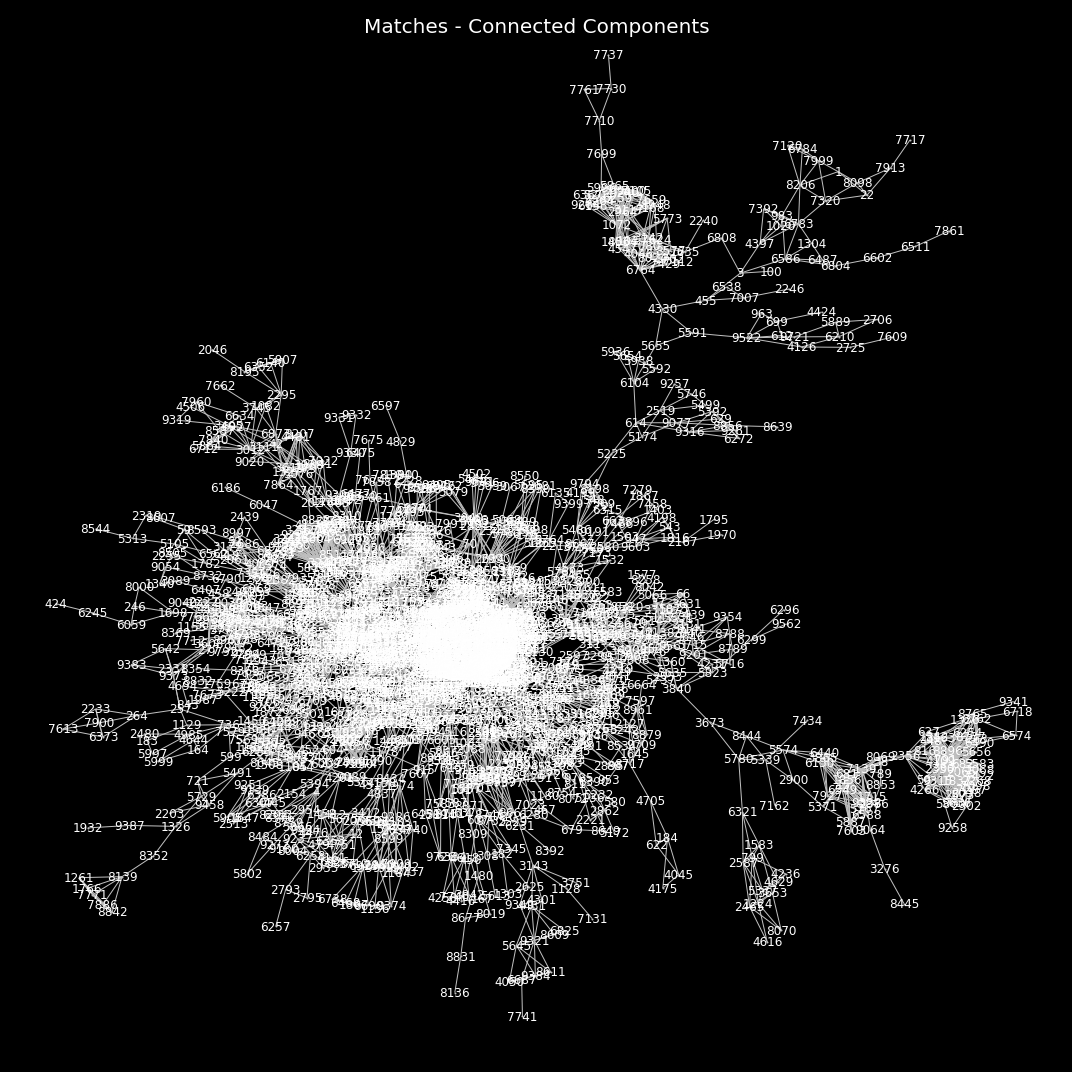

In [39]:
fig = plt.figure(figsize=(15,15), facecolor="black")
ax = nx.draw_networkx(G,
                      with_labels=True,
                      node_size=1,
                      alpha=1,
                      pos=nx.kamada_kawai_layout(G),
#                       pos=nx.spring_layout(G),
                      edge_color="silver",
                      node_color="silver",
                     font_size=12,
                     font_color="white")
plt.axis("off")
plt.tight_layout()
plt.suptitle("Matches - Connected Components", fontsize=20, color="white")
plt.show()

In [63]:
# Print pair of entities
print(df.loc[8352]["entityname"])
print(df.loc[8842]["entityname"])

School of Computer Science and Engineering, The Hebrew University of Jerusalem, Israel
School of Computer Science and Engineering, University of New South Wales, NICTA, Sydney, Australia NSW 2052


In [41]:
# Current score for a pair that was not found
fuzz.ratio("Hong Kong University of Science and Technology, China",
          "The Hong Kong University of Science and Technology, Hong Kong, China")

88

In [42]:
# Same pair as above but with stopword removal
fuzz.ratio("Hong Kong University Science Technology China",
          "Hong Kong University Science Technology Hong Kong China")

90

In [43]:
# Connected component subgraphs
cc_subgraphs = list(nx.connected_components(G))

In [44]:
len(cc_subgraphs)

131

In [45]:
# list(cc_subgraphs[1])

In [46]:
# Generate all matching pairs based on connected components
match_pairs = []
for subgraph in cc_subgraphs:
    cc = list(subgraph)
    cc.sort()
    combos = list(itertools.combinations(cc, 2))
    for c in combos:
        match_pairs.append(c)
#     print(combos)
#     print("-"*72)

In [47]:
len(match_pairs)

956902

In [48]:
match_pairs[:10]

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 12),
 (1, 15),
 (1, 18),
 (1, 20)]

In [49]:
df_ccmatches = pd.DataFrame(match_pairs)
df_ccmatches.columns = ["entityid1", "entityid2"]
df_ccmatches["match_string"] = df_ccmatches.apply(lambda row: str(row["entityid1"])+"|"+str(row["entityid2"]), axis=1)
df_ccmatches.head()

,entityid1,entityid2,match_string
0,1,2,1|2
1,1,3,1|3
2,1,4,1|4
3,1,6,1|6
4,1,7,1|7


In [50]:
df_ccmatches.shape

(956902, 3)

In [51]:
ccmatches_list = list(df_ccmatches["match_string"])

In [52]:
good_ccmatches = []
for m in ccmatches_list:
    if m in truth_list:
        good_ccmatches.append("Good match")
    else:
        good_ccmatches.append("Bad match")

In [53]:
df_ccmatches["GoodBad"] = good_ccmatches

In [54]:
df_ccmatches.head()

,entityid1,entityid2,match_string,GoodBad
0,1,2,1|2,Bad match
1,1,3,1|3,Good match
2,1,4,1|4,Bad match
3,1,6,1|6,Bad match
4,1,7,1|7,Bad match


In [55]:
df_ccmatches["GoodBad"].value_counts()

Bad match     945037
Good match     11865
Name: GoodBad, dtype: int64

In [56]:
found_good_matches = list(df_ccmatches.loc[df_ccmatches["GoodBad"]=="Good match"]["match_string"])

In [57]:
truth_not_found = []
for t in truth_list:
    if t not in found_good_matches:
        truth_not_found.append(t)
print(f"Number of truths not found: {len(truth_not_found)}")

Number of truths not found: 4543


In [58]:
found_good_matches[:10]

['1|3',
 '1|22',
 '1|455',
 '1|983',
 '1|1020',
 '1|1304',
 '1|2246',
 '1|4330',
 '1|4397',
 '1|6487']

<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 75 (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     221405</li>
        <li>Good match     7261</li>
        <li>Good/Bad     0.03</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 80  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     15725</li>
        <li>Good match     4719</li>
        <li>Good/Bad     0.3</li>
    </ul>
</div>


<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 85  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     2253</li>
        <li>Good match     2706</li>
        <li>Good/Bad     1.20</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 88  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     666</li>
        <li>Good match     2127</li>
        <li>Good/Bad     3.19</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 3 groups and threshold at 90  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     165</li>
        <li>Good match     1339</li>
        <li>Good/Bad     8.12</li>
    </ul>
</div>

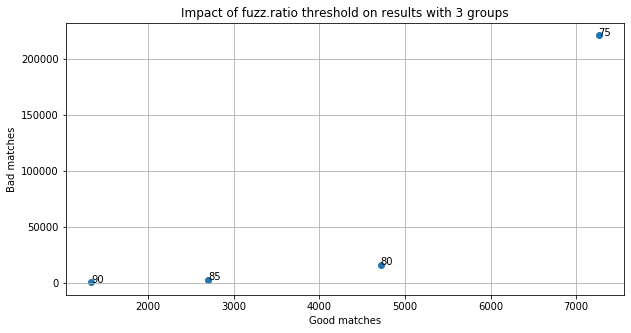

In [59]:
labels=[75,80,85,90]
x=[7261,4719,2706,1339]
y=[221405,15725,2253,165]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x=x, y=y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

# plt.axis("equal")
# plt.xlim(left=0, right=max(y))
plt.title("Impact of fuzz.ratio threshold on results with 3 groups")
plt.xlabel("Good matches")
plt.ylabel("Bad matches")
plt.grid()

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 90  (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     218</li>
        <li>Good match     1608</li>
        <li>Good/Bad     7.38</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 90  (with stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     227</li>
        <li>Good match     1499</li>
        <li>Good/Bad     6.60</li>
    </ul>
</div>

<div style="background-color:black; color:white;">
    <h3>Results with 10 groups and threshold at 75 and average ratio method (no stopword removal)</h3>
    <hr>
    <ul>
        <li>Bad match     945037</li>
        <li>Good match     11865</li>
        <li>Good/Bad     0.01</li>
    </ul>
</div>